In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Data Treatment

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer


# Machine Learning
%load_ext cuml.accel
import os
import cudf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from optuna.samplers import TPESampler
from xgboost import XGBRegressor # For stacking
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import RidgeCV, BayesianRidge, ElasticNet, Ridge, LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.feature_selection import SelectFromModel

# Statistics

from statsmodels.stats.outliers_influence import variance_inflation_factor

[2025-10-29 19:34:50.431] [CUML] [info] cuML: Installed accelerator for sklearn.


2025-10-29 19:35:07.676806: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761766508.131065      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761766508.272344      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[2025-10-29 19:35:36.237] [CUML] [info] cuML: Installed accelerator for umap.
[2025-10-29 19:35:36.309] [CUML] [info] cuML: Installed accelerator for hdbscan.
[2025-10-29 19:35:36.309] [CUML] [info] cuML: Successfully initialized accelerator.


In [ ]:
df = pd.read_csv('/kaggle/input/playground-series-s5e10/train.csv')

# First Analysis

In [ ]:
df

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517749,517749,highway,4,0.10,70,daylight,foggy,True,True,afternoon,False,False,2,0.32
517750,517750,rural,4,0.47,35,daylight,rainy,True,True,morning,False,False,1,0.26
517751,517751,urban,4,0.62,25,daylight,foggy,False,False,afternoon,False,True,0,0.19
517752,517752,highway,3,0.63,25,night,clear,True,False,afternoon,True,True,3,0.51


Analysis:

- We dont have NaN values and that's good.


In [ ]:
df.duplicated().sum()

0

# Pre-Processing

## Statistical Analysis

In [ ]:
df

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517749,517749,highway,4,0.10,70,daylight,foggy,True,True,afternoon,False,False,2,0.32
517750,517750,rural,4,0.47,35,daylight,rainy,True,True,morning,False,False,1,0.26
517751,517751,urban,4,0.62,25,daylight,foggy,False,False,afternoon,False,True,0,0.19
517752,517752,highway,3,0.63,25,night,clear,True,False,afternoon,True,True,3,0.51


Analysis:

- We have more categorical features than numeric features
- speed_limit and num_lanes are categorical features
- Only the target variable and curvature are numeric features

### Analyzing the target variable

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


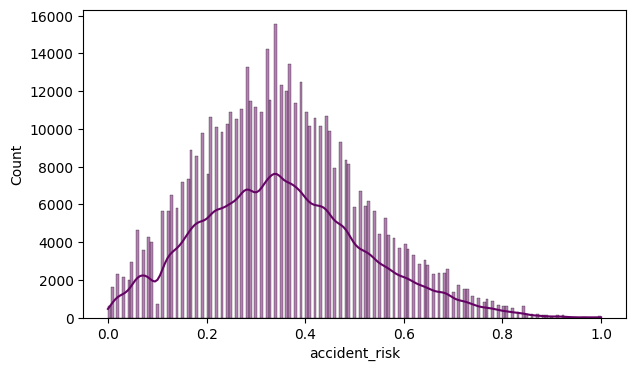

count    517754.000000
mean          0.352377
std           0.166417
min           0.000000
25%           0.230000
50%           0.340000
75%           0.460000
max           1.000000
Name: accident_risk, dtype: float64


In [ ]:
plt.figure(figsize = (7, 4))
sns.histplot(data = df, x = df.accident_risk, kde = True, color = '#660465')
plt.show()

print(df.accident_risk.describe())

Analysis:

- The target variable is lightly distorted to the left. Probably because of outliers
- Most of the samples are close to the mean, which indicates that our variable is almost normal

### Multivariable Analysis

In [ ]:
df1 = df.copy()

In [ ]:
df1

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517749,517749,highway,4,0.10,70,daylight,foggy,True,True,afternoon,False,False,2,0.32
517750,517750,rural,4,0.47,35,daylight,rainy,True,True,morning,False,False,1,0.26
517751,517751,urban,4,0.62,25,daylight,foggy,False,False,afternoon,False,True,0,0.19
517752,517752,highway,3,0.63,25,night,clear,True,False,afternoon,True,True,3,0.51


Let's first treat the object features using ordinal_encoder.

In [ ]:
object_features = ['road_type', 'lighting', 'weather', 'road_signs_present', 'public_road', 'time_of_day', 'holiday', 'school_season']
numeric_features = ['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents']

Note that we considered 'num_lanes' and 'speed_limit' inside of the numeric features list. They ARE NOT numeric, but we are using the sk-learn to treat the data so we have to separate them

In [ ]:
ordinal_encoder = OrdinalEncoder()

In [ ]:
df_cat = ordinal_encoder.fit_transform(df1[object_features])
df_cat = pd.DataFrame(df_cat, columns=ordinal_encoder.get_feature_names_out())
df_cat.head()

,road_type,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season
0,2.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0
1,2.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
2,1.0,1.0,0.0,0.0,1.0,2.0,1.0,0.0
3,0.0,1.0,2.0,1.0,1.0,2.0,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


In [ ]:
df1.drop(object_features,axis=1,inplace=True)
df1 = pd.concat([df1, df_cat],axis=1)

In [ ]:
df1

,id,num_lanes,curvature,speed_limit,num_reported_accidents,accident_risk,road_type,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season
0,0,2,0.06,35,1,0.13,2.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0
1,1,4,0.99,35,0,0.35,2.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
2,2,4,0.63,70,2,0.30,1.0,1.0,0.0,0.0,1.0,2.0,1.0,0.0
3,3,4,0.07,35,1,0.21,0.0,1.0,2.0,1.0,1.0,2.0,0.0,0.0
4,4,1,0.58,60,1,0.56,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517749,517749,4,0.10,70,2,0.32,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
517750,517750,4,0.47,35,1,0.26,1.0,0.0,2.0,1.0,1.0,2.0,0.0,0.0
517751,517751,4,0.62,25,0,0.19,2.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
517752,517752,3,0.63,25,3,0.51,0.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0


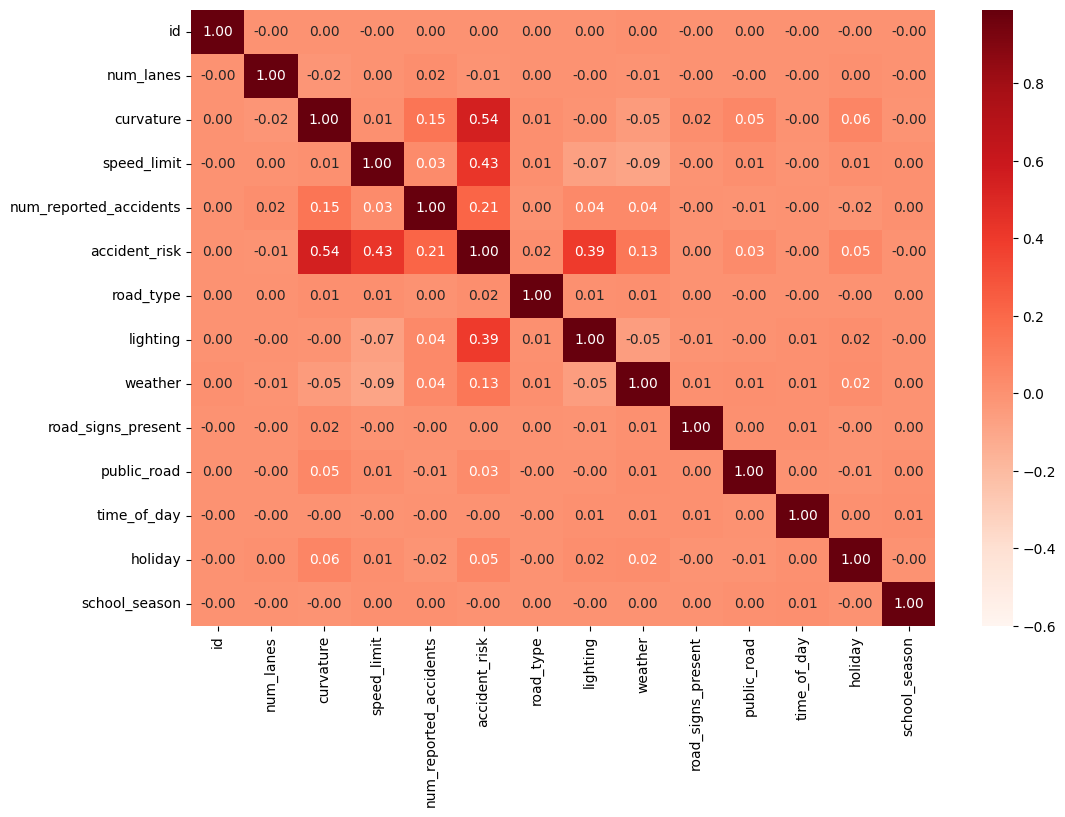

In [ ]:
plt.figure(figsize = (12,8))

sns.heatmap(df1.corr(), annot = True, fmt = '.2f', cmap = 'Reds', vmax = .99, vmin = -0.60)
plt.show()

Since we are not here to provide INSIGHTS we are going to remove the variables with high multicolinearity quickly

In [ ]:
def verify_vif(train):

    vif = pd.DataFrame()

    vif["feature"] = train.columns

    vif["VIF"] = [variance_inflation_factor(train.values, i) for i in range(len(train.columns))]

    return vif

In [ ]:
verify_vif(df1.drop('accident_risk', axis=1))

,feature,VIF
0,id,3.627034
1,num_lanes,5.014432
2,curvature,4.000525
3,speed_limit,6.853073
4,num_reported_accidents,2.778004
5,road_type,2.388253
6,lighting,2.294471
7,weather,2.283149
8,road_signs_present,1.938573
9,public_road,1.967110


Speed_limit has a bigger scale compared to the rest of the variables, so we are going to treat this with StandardScaler

In [ ]:
df1

,id,num_lanes,curvature,speed_limit,num_reported_accidents,accident_risk,road_type,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season
0,0,2,0.06,35,1,0.13,2.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0
1,1,4,0.99,35,0,0.35,2.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
2,2,4,0.63,70,2,0.30,1.0,1.0,0.0,0.0,1.0,2.0,1.0,0.0
3,3,4,0.07,35,1,0.21,0.0,1.0,2.0,1.0,1.0,2.0,0.0,0.0
4,4,1,0.58,60,1,0.56,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517749,517749,4,0.10,70,2,0.32,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
517750,517750,4,0.47,35,1,0.26,1.0,0.0,2.0,1.0,1.0,2.0,0.0,0.0
517751,517751,4,0.62,25,0,0.19,2.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
517752,517752,3,0.63,25,3,0.51,0.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0


In [ ]:
scaler = StandardScaler()
df1_scaled = scaler.fit_transform(df1.drop('accident_risk', axis=1))
df1_scaled = pd.DataFrame(df1_scaled, columns=scaler.get_feature_names_out())
df1_scaled.head()

,id,num_lanes,curvature,speed_limit,num_reported_accidents,road_type,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season
0,-1.732047,-0.438680,-1.572918,-0.703840,-0.209797,1.230465,-1.193722,1.296155,-0.998410,0.995498,-1.229708,-1.007020,1.004984
1,-1.732041,1.346344,1.839137,-0.703840,-1.325918,1.230465,-1.193722,-1.189016,1.001593,-1.004522,-0.004503,0.993029,1.004984
2,-1.732034,1.346344,0.518342,1.512963,0.906324,0.005463,0.053230,-1.189016,-0.998410,0.995498,1.220702,0.993029,-0.995041
3,-1.732027,1.346344,-1.536229,-0.703840,-0.209797,-1.219538,0.053230,1.296155,1.001593,0.995498,1.220702,-1.007020,-0.995041
4,-1.732021,-1.331192,0.334898,0.879591,-0.209797,0.005463,-1.193722,0.053569,-0.998410,-1.004522,-0.004503,0.993029,-0.995041


In [ ]:
df1_scaled['accident_risk'] = df1['accident_risk']

In [ ]:
verify_vif(df1_scaled)

,feature,VIF
0,id,1.000018
1,num_lanes,1.000940
2,curvature,1.093923
3,speed_limit,1.063030
4,num_reported_accidents,1.031082
5,road_type,1.000533
6,lighting,1.051277
7,weather,1.028966
8,road_signs_present,1.000520
9,public_road,1.003107


Great! We don't have any multicollinearity!

In [ ]:
# Creating data treatment function

import numpy as np
from sklearn.preprocessing import PolynomialFeatures


def data_treatment(df, ordinal_encoder, scaler):
    cat_feats = ['road_type', 'lighting', 'weather', 'road_signs_present',
                 'public_road', 'time_of_day', 'holiday', 'school_season']
    num_feats = ['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents']

    pipeline = Pipeline([
        ('preprocess', ColumnTransformer([('cat', ordinal_encoder, cat_feats), ('num', 'passthrough', num_feats)]))])


    df = pipeline.fit_transform(df)
    return pd.DataFrame(df, columns=pipeline.get_feature_names_out())

In [ ]:
df_train  = data_treatment(df, ordinal_encoder, scaler)

In [ ]:
df_train['accident_risk'] = df['accident_risk']

# Modeling

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

X = df_train.drop('accident_risk', axis=1)
y = df_train['accident_risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)

In [ ]:
X_train

,cat__road_type,cat__lighting,cat__weather,cat__road_signs_present,cat__public_road,cat__time_of_day,cat__holiday,cat__school_season,num__num_lanes,num__curvature,num__speed_limit,num__num_reported_accidents
480272,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,4.0,0.52,45.0,0.0
147591,1.0,1.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0,0.15,35.0,3.0
283894,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,2.0,0.56,45.0,0.0
25819,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,0.11,60.0,1.0
486351,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,4.0,0.24,60.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
259178,1.0,1.0,0.0,0.0,1.0,2.0,1.0,0.0,4.0,0.05,60.0,1.0
365838,1.0,1.0,2.0,0.0,0.0,1.0,1.0,1.0,3.0,0.47,70.0,1.0
131932,0.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,3.0,0.51,70.0,2.0
146867,1.0,2.0,2.0,1.0,0.0,1.0,0.0,0.0,3.0,0.91,60.0,4.0


### RandomForest

In [ ]:
regr = RandomForestRegressor(max_depth=2, random_state=0)

regr_scores = cross_val_score(regr, X, y, cv=kf, scoring="neg_root_mean_squared_error")

print(f'RandomForest RMSE: {np.mean(-regr_scores)}')

[2025-10-29 19:35:56.628] [CUML] [info] Unused keyword parameter: ccp_alpha during cuML estimator initialization


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: The split criterion chosen was not present in the list of options accepted by the model and so the CRITERION_END option has been chosen.
  return init_func(self, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: The split criterion chosen was not present in the list of options accepted by the model and so the CRITERION_END option has been chosen.
  return init_func(self, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: The split criterion chosen was not present in the list of options accepted by the model and so the CRITERION_END option has been chosen.
  return init_func(self, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: The split criterion chosen was not present in the list of options accepted by the model and so the 

RandomForest RMSE: 0.11866748285520243


### BayesianRidge

In [ ]:
from sklearn import linear_model
clf = linear_model.BayesianRidge()

clf_scores = cross_val_score(clf, X, y, cv=kf, scoring="neg_root_mean_squared_error")

print(f'BayesianRidge RMSE: {np.mean(-clf_scores)}')


BayesianRidge RMSE: 0.08853971958935952


### SVR

In [ ]:
from sklearn.linear_model import SGDRegressor


sgd_model = SGDRegressor(max_iter=1000, tol=1e-3)

sgd_scores = cross_val_score(sgd_model, X, y, cv=kf, scoring="neg_root_mean_squared_error")

print(f'SGD RMSE: {np.mean(-sgd_scores)}')

SGD RMSE: 0.10286775674910924


### XGboost

In [ ]:
from xgboost import XGBRegressor

bst = XGBRegressor(n_estimators=2, max_depth=2, learning_rate=1, objective='reg:squarederror')


bst_scores = cross_val_score(bst, X, y, cv=kf, scoring="neg_root_mean_squared_error")

print(f'XGBoost RMSE: {np.mean(-bst_scores)}')

XGBoost RMSE: 0.07596223510710047


### MLP

In [ ]:
from sklearn.neural_network import MLPRegressor

regr = MLPRegressor(random_state=1, max_iter=2000, tol=0.1)

regr_scores = cross_val_score(regr, X, y, cv=kf, scoring="neg_root_mean_squared_error")

print(f'MLP RMSE: {np.mean(-regr_scores)}')


MLP RMSE: 0.062034045039364064


# Stacking model with the base models (not optimized with hyperparameter search)

In [ ]:
class meta_model():
    def __init__(self, base_models : list, final_model):
        self.base_models = base_models
        self.final_model = final_model
        self.oof_train = None


    def train_(self, X_train, y_train, verbose = 0):

        oof_train = {}

        for model in self.base_models:

            current_model =  type(model).__name__

            if verbose == 1:
                print(f'Current Model Training: {current_model}')

            oof_preds = np.zeros(len(y_train))

            for fold, (tr_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
                X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
                y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]

                model.fit(X_tr, y_tr)

                y_pred = model.predict(X_val)
                oof_preds[val_idx] = y_pred

            if current_model not in oof_train:
                oof_train[current_model] = []
            oof_train[current_model].append(oof_preds)

        self.oof_train = pd.DataFrame({
            k: v[0] for k, v in oof_train.items() if len(v) > 0
        })


    def fit_(self, X_train, y_train, verbose = 0):

        self.train_(X_train, y_train, verbose=verbose)

        self.final_model.fit(self.oof_train, y_train)


    def predict_(self, X_test, verbose = 0):
        oof_pred_test = {}

        for model in self.base_models:
            current_model = type(model).__name__

            if verbose == 1:
                print(f'Current Model Inference: {current_model}')

            y_pred = model.predict(X_test)

            if current_model not in oof_pred_test:
                oof_pred_test[current_model] = []
            oof_pred_test[current_model].append(y_pred)

        oof_pred_test = pd.DataFrame({k: v[0] for k, v in oof_pred_test.items()})

        y_meta_pred = self.final_model.predict(oof_pred_test)

        return y_meta_pred

In [ ]:
cat_model = CatBoostRegressor(
    verbose=0,
    random_state=42,
    task_type="GPU"
)

lgbm_model = LGBMRegressor(
    random_state=42,
    device="gpu",
    gpu_platform_id=0,
    gpu_device_id=0,
    verbose=0
)

gbr_model = GradientBoostingRegressor(random_state=42)
xgb_model = XGBRegressor(n_estimators=2, max_depth=2, learning_rate=1, objective='reg:squarederror')
mlp_model = MLPRegressor(random_state=1, max_iter=2000, tol=0.1)

# Meta-model
ridge_model = Ridge()

models_list = [cat_model, lgbm_model, gbr_model, xgb_model, mlp_model]

In [ ]:
competition_model = meta_model(models_list, ridge_model)
competition_model.fit_(X_train, y_train, verbose=1)

Current Model Training: CatBoostRegressor
Current Model Training: LGBMRegressor


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Current Model Training: GradientBoostingRegressor
Current Model Training: XGBRegressor
Current Model Training: MLPRegressor


In [ ]:
y_pred = competition_model.predict_(X_test)

rmse_meta = np.sqrt(mean_squared_error(y_test, y_pred))
print(rmse_meta)

0.056277645404482095


## Optimizing Meta-Model

In [ ]:
print('Searching the best hyperparameters...\n')

def objective(trial):
    params = {
        "alpha": trial.suggest_float("alpha", 1e-3, 1e3, log=True),
        "solver": trial.suggest_categorical(
            "solver",
            ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "saga", "sag"]
        )
    }

    oof_preds = np.zeros(len(competition_model.oof_train))
    rmse_scores = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(competition_model.oof_train, y_train)):
        X_tr, X_val = competition_model.oof_train.iloc[train_idx], competition_model.oof_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = Ridge(**params)
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)

        oof_preds[val_idx] = preds
        rmse_scores.append(np.sqrt(mean_squared_error(y_val, preds)))

    global_rmse = np.sqrt(mean_squared_error(y_train, oof_preds))
    print(f"Global OOF RMSE: {global_rmse:.5f}")

    return np.mean(rmse_scores)


study = optuna.create_study(direction="minimize", sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=25, show_progress_bar=True)

print("\nDone!")
print(f"Best CV RMSE: {study.best_value:.5f}")
print("Best params:", study.best_params)



[I 2025-10-29 19:52:12,441] A new study created in memory with name: no-name-9d373512-edee-40c1-8312-733ffd00406c


Searching the best hyperparameters...



  0%|          | 0/25 [00:00<?, ?it/s]

Global OOF RMSE: 0.05606
[I 2025-10-29 19:52:17,443] Trial 0 finished with value: 0.05606124332781588 and parameters: {'alpha': 0.1767016940294795, 'solver': 'auto'}. Best is trial 0 with value: 0.05606124332781588.
Global OOF RMSE: 0.05607
[I 2025-10-29 19:52:22,456] Trial 1 finished with value: 0.05606751980331705 and parameters: {'alpha': 4.0428727350273315, 'solver': 'cholesky'}. Best is trial 0 with value: 0.05606124332781588.
Global OOF RMSE: 0.05606
[I 2025-10-29 19:52:27,436] Trial 2 finished with value: 0.05606125121198391 and parameters: {'alpha': 0.06690421166498801, 'solver': 'lsqr'}. Best is trial 0 with value: 0.05606124332781588.
Global OOF RMSE: 0.05606
[I 2025-10-29 19:52:32,429] Trial 3 finished with value: 0.05606133304236231 and parameters: {'alpha': 0.5450293694558254, 'solver': 'auto'}. Best is trial 0 with value: 0.05606124332781588.
Global OOF RMSE: 0.05606
[I 2025-10-29 19:52:33,260] Trial 4 finished with value: 0.05606126387408862 and parameters: {'alpha': 0.0

In [ ]:
ridge_model = Ridge(**study.best_params)
competition_model = meta_model(models_list, ridge_model)
competition_model.fit_(X_train, y_train, verbose=1)

Current Model Training: CatBoostRegressor
Current Model Training: LGBMRegressor
Current Model Training: GradientBoostingRegressor
Current Model Training: XGBRegressor
Current Model Training: MLPRegressor


In [ ]:
y_pred = competition_model.predict_(X_test)

rmse_meta = np.sqrt(mean_squared_error(y_test, y_pred))
print(rmse_meta)

0.05627666948748358


# Submission

In [ ]:
df_test = pd.read_csv('/kaggle/input/playground-series-s5e10/test.csv')
df_final = data_treatment(df_test, ordinal_encoder, scaler)
df_final.head()

,cat__road_type,cat__lighting,cat__weather,cat__road_signs_present,cat__public_road,cat__time_of_day,cat__holiday,cat__school_season,num__num_lanes,num__curvature,num__speed_limit,num__num_reported_accidents
0,0.0,2.0,0.0,1.0,1.0,0.0,1.0,1.0,2.0,0.34,45.0,1.0
1,2.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,3.0,0.04,45.0,0.0
2,2.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,0.59,35.0,1.0
3,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,0.95,35.0,2.0
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0,0.86,35.0,3.0


In [ ]:
oof_submission = competition_model.predict_(df_final)

In [ ]:
df_submission = {'id' : df_test['id'], 'accident_risk' : oof_submission}

df_submission = pd.DataFrame.from_dict(df_submission)

df_submission.to_csv('submission.csv', index=False)

In [ ]:
df_submission

,id,accident_risk
0,517754,0.289538
1,517755,0.123134
2,517756,0.184740
3,517757,0.307797
4,517758,0.402348
...,...,...
172580,690334,0.108116
172581,690335,0.521439
172582,690336,0.249017
172583,690337,0.128313
